In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import cv2
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input.

# from tensorflow.keras.layers import Embedding
# from keras import models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

#from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv')

In [3]:
#이미지 크기 확대
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') #resize에러 float32로 바꿔 해결함
x_train = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_train]
#x_train = x_train/255 # data 정규화
#img=x_train[0].reshape(28,28).astype(int)

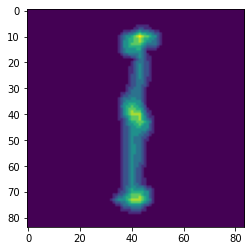

In [4]:
#3배 확대하여 stretching : 오래 걸림.. 컴퓨터야 미안!

def stretch_img(img): #(2048,28,28,1) 반복문으로 넣음
    #img=img.reshape(28,28).astype(int)
    #img=Image.fromarray(img)
    row = 84
    col = 84
    stretch_img = np.zeros((84,84))
    high = 0
    low = 8

    for x in range(1 , row):
        for y in range(1, col):
            if high < img[x,y] :
                high = img[x,y]
            if low > img[x,y]:
                low = img[x,y]
    for x in range(1 , row):
        for y in range(1, col):
            stretch_img[x,y]=int((img[x,y]-low)*8/(high-low))
   
    return stretch_img#스트레칭된 이미지 출력


x__train=[ stretch_img(img) for img in x_train]
plt.imshow(x__train[0])
#stretch_img(x_train[0]) 

In [10]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)

    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)

    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
create_cnn_model().summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_9 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 42, 42, 64)       

In [12]:
#1: stretch로 학습
x__train=np.array(x__train).reshape(-1,84,84,1) 
x__train=x__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y_ = train['digit']
Y_train = np.zeros((len(y_), len(y_.unique())))
for i, digit in enumerate(y_):
    Y_train[i, digit] = 1
    
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=300

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(x__train, Y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/300
128/128 [==============================] - 10s 80ms/step - loss: 4.1421 - accuracy: 0.2915
Epoch 2/300
128/128 [==============================] - 10s 79ms/step - loss: 2.5855 - accuracy: 0.3994
Epoch 3/300
128/128 [==============================] - 10s 79ms/step - loss: 2.2419 - accuracy: 0.4648
Epoch 4/300
128/128 [==============================] - 10s 82ms/step - loss: 2.1574 - accuracy: 0.5039
Epoch 5/300
128/128 [==============================] - 10s 79ms/step - loss: 2.0015 - accuracy: 0.5562
Epoch 6/300
128/128 [==============================] - 10s 81ms/step - loss: 1.8533 - accuracy: 0.5908
Epoch 7/300
128/128 [==============================] - 10s 80ms/step - loss: 1.7508 - accuracy: 0.6089
Epoch 8/300
128/128 [==============================] - 10s 80ms/step - loss: 1.7136 - accuracy: 0.6343
Epoch 9/300
128/128 [==============================] - 10s 80ms/step - loss: 1.5772 - accuracy: 0.6602
Epoch 10/300
128/128 [==============================] - 10s 80ms/step - l

128/128 [==============================] - 10s 80ms/step - loss: 0.2765 - accuracy: 0.9761
Epoch 156/300
128/128 [==============================] - 10s 80ms/step - loss: 0.2740 - accuracy: 0.9834
Epoch 157/300
128/128 [==============================] - 10s 80ms/step - loss: 0.2811 - accuracy: 0.9810
Epoch 158/300
128/128 [==============================] - 10s 80ms/step - loss: 0.2648 - accuracy: 0.9858
Epoch 159/300
128/128 [==============================] - 10s 79ms/step - loss: 0.2631 - accuracy: 0.9854
Epoch 160/300
128/128 [==============================] - 10s 80ms/step - loss: 0.2729 - accuracy: 0.9829
Epoch 161/300
128/128 [==============================] - 10s 80ms/step - loss: 0.2555 - accuracy: 0.9893
Epoch 162/300
128/128 [==============================] - 10s 80ms/step - loss: 0.2720 - accuracy: 0.9795
Epoch 163/300
128/128 [==============================] - 10s 81ms/step - loss: 0.2676 - accuracy: 0.9819
Epoch 164/300
128/128 [==============================] - 10s 81ms/ste

In [17]:
#2:이진화하여 학습
X__train = x__train*8
X__train = [ cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in X__train ] #이진화
X__train=np.array(X__train).reshape(-1,84,84,1) 
X__train=X__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

#threshold함수는 임계치와 이미지를 return하는것을 잊지말자..

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1
    
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model() #엥 이거있으면 안되는데........?
epochs=100

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(X__train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = X__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/100
128/128 [==============================] - 10s 79ms/step - loss: 2.9323 - accuracy: 0.3447
Epoch 2/100
128/128 [==============================] - 10s 79ms/step - loss: 2.1626 - accuracy: 0.4058
Epoch 3/100
128/128 [==============================] - 10s 79ms/step - loss: 1.8860 - accuracy: 0.4634
Epoch 4/100
128/128 [==============================] - 11s 83ms/step - loss: 1.7404 - accuracy: 0.4858
Epoch 5/100
128/128 [==============================] - 10s 80ms/step - loss: 1.6490 - accuracy: 0.5049
Epoch 6/100
128/128 [==============================] - 10s 80ms/step - loss: 1.5691 - accuracy: 0.5229
Epoch 7/100
128/128 [==============================] - 10s 80ms/step - loss: 1.5246 - accuracy: 0.5415
Epoch 8/100
128/128 [==============================] - 10s 80ms/step - loss: 1.4820 - accuracy: 0.5483
Epoch 9/100
128/128 [==============================] - 10s 80ms/step - loss: 1.4689 - accuracy: 0.5459
Epoch 10/100
128/128 [==============================] - 10s 79ms/step - l

In [18]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_test = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_test]
#x_test1 = [cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in x_test1 ] #이진화
#x_test=[ stretch_img(img) for img in x_test11] #stretch
x_test = np.array(x_test).reshape(-1, 84, 84, 1)
x_test = x_test/8


#submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)

submission.head(50)

,id,digit
0,2049,2
1,2050,2
2,2051,5
3,2052,2
4,2053,8
5,2054,8
6,2055,8
7,2056,8
8,2057,8
9,2058,8
